In [1]:
# --- Imports ---
import sys,os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import struct
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans2, whiten
from scipy import stats
from numpy.random import uniform
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib import ticker
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import math
from geopandas import GeoDataFrame, GeoSeries
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
import shapely
%matplotlib inline

In [30]:
ev = pd.read_csv('./data/everything.csv', skiprows=1, usecols=[2,3,4,5], header=None, names=["rand", "s2", "num", "lat", "lng", "time"])
mon = pd.read_csv('./data/pokemon.csv', skiprows=1, usecols=[3,4,5,6], names=["num", "lat", "lng", "time"], low_memory=False)
loc = pd.read_csv('./data/pokeloc.csv', skiprows=1, usecols=[1,4,5,6], names=["num","time", "lat", "lng"], low_memory=False)
frames = [ev, mon, loc]
mons = pd.concat(frames, ignore_index=True)
mons.last_valid_index()

9252095

In [ ]:
def plotdat(data,cat):
    l=data.groupby(cat).size()
    l.sort()
    fig=plt.figure(figsize=(40,5))
    plt.yticks(fontsize=8)
    l.plot(kind='bar',fontsize=12,color='k')
    plt.xlabel('')
    plt.ylabel('Number of reports',fontsize=10)



In [ ]:
# example showing how to plot scattered data with hexbin.

# create north polar stereographic basemap
# bay area
m = Basemap(width=100000,height=100000,lon_0=-122.0,lat_0=37.6,lon_1=-121.4,lat_1=41.8, projection='lcc',resolution='h')
#world
#m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90, llcrnrlon=-180,urcrnrlon=180,resolution='c')
#east coast
#m = Basemap(projection='mill',llcrnrlat=30,urcrnrlat=46, llcrnrlon=-92,urcrnrlon=-60,resolution='c')
#germany + nether
#m = Basemap(projection='mill',llcrnrlat=40,urcrnrlat=54, llcrnrlon=0,urcrnrlon=14,resolution='l')
#germany
#m = Basemap(width=100000,height=100000,lon_0=13.408080,lat_0=52.515116,lon_1=-121.5,lat_1=39, projection='lcc',resolution='h')


#m = Basemap(lon_0=-105,lat_0=40,projection='ortho')
#m.bluemarble()

#m = Basemap(projection='ortho',lon_0=-122.2829538,lat_0=37.5915934,resolution='l',\
#             llcrnrx=-400*1000,llcrnry=-400*1000,
#             urcrnrx=+300*1000,urcrnry=+300*1000)


In [ ]:

def colorbar_index(ncolors, mnum, cmap):
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, orientation='horizontal',  drawedges=True, )
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(mnum)

def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki])
                       for i in xrange(N+1) ]
    # Return colormap object.
    return mcolors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)


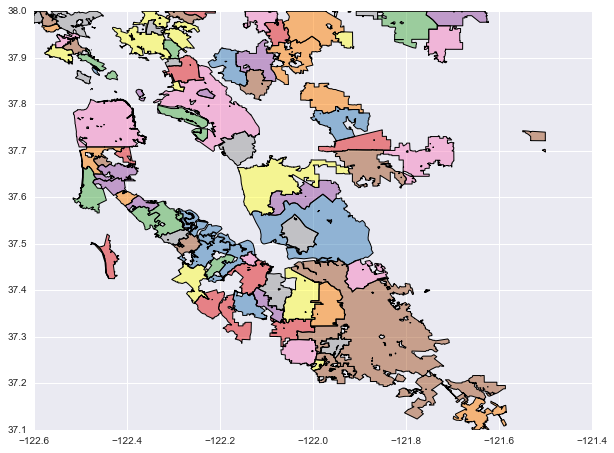

In [2]:

#bayarea = Polygon([(-123, 36), (-121,36), (-121,39), (-123,39)])
bayarea = Polygon([(-122.6, 37.1), (-121.5,37.1), (-121.5,38), (-122.6,38)])
df = GeoDataFrame(geometry=GeoSeries([bayarea]),crs={'init': 'epsg:4269'})


ca_cities = GeoDataFrame.from_file('./geodata/ca_cities/Cities2015.shp').intersection(df.geometry.unary_union)
ca_water = GeoDataFrame.from_file('./geodata/baywater/bayarea_allwater.shp').to_crs(ca_cities.crs)

ca_cities_clean = ca_cities.difference(ca_water.geometry.unary_union)
ca_cities_clean.plot(figsize=(10,10))
#cccu = ca_cities_clean.geometry.unary_union


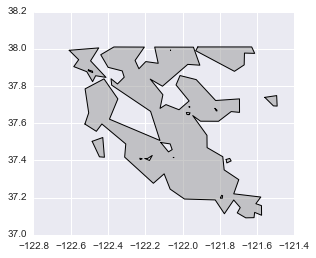

In [22]:

simple_ca = GeoDataFrame(geometry=GeoSeries(ca_cities_clean.buffer(0).geometry.unary_union),crs={'init': 'epsg:4269'})
simple_ca = simple_ca.buffer(0.01).simplify(0.02, preserve_topology=True)
#simple_ca = simple_ca.buffer(0.01)
simple_ca.plot()
#ca_cities_clean = ca_cities_clean.geometry.unary_union.simplify(0.002, preserve_topology=True)
#GeoDataFrame(geometry=GeoSeries([bayarea]),crs={'init': 'epsg:4269'})
#ca_cities_clean.plot(figsize=(10,10))

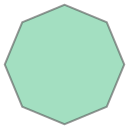

In [18]:
shapely.affinity.scale(Point(0,0).buffer(6).simplify(0.8, preserve_topology=False), xfact=10, yfact=10)

CPU times: user 372 ms, sys: 20 ms, total: 392 ms
Wall time: 2.02 s


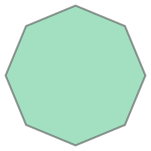

In [4]:
import multiprocessing

circles = []
xoffset = 0
yoffset = 0
r = 70

def create_point(data):
    i = data[0]
    j = data[1]
    p = Point(i*r*math.sqrt(3) + (r*math.sqrt(3)/2 if j%2 else 0) + xoffset, 
                             j*r*3/4*2+yoffset)
    return shapely.affinity.scale(p.buffer(7).simplify(0.8, preserve_topology=False), xfact=r/7, yfact=r/7)

for i in range(0, 100):
    for j in range(0, 100):
        circles.append([i,j])

pool = multiprocessing.Pool(multiprocessing.cpu_count()-1)
%time circles = pool.map(create_point, circles)

circles[0]

In [12]:
math.sqrt(circles[0].area/math.pi)

66.41949976603121

In [11]:

# EPSG:2768 ca meters
search_circles = GeoDataFrame(geometry=GeoSeries(circles))
df = GeoDataFrame(geometry=GeoSeries(circles))
df.crs = {'init': 'epsg:2768'}
%time df = df.to_crs(ca_cities_clean.crs)

#gpd.overlay(simple_ca, GeoDataFrame(geometry=df), how='intersection').plot(figsize=(10,10))
#query_plan = df.intersection(simple_ca.buffer(0).geometry.unary_union)
#query_plan.plot(figsize=(10,10))
#df.union(ca_cities_clean.geometry.unary_union).plot(figsize=(10,10))

#df.plot(ax=ca_cities_clean.plot(figsize=(10,10)), figsize=(10,10))

#math.sqrt(Point(0, 0).buffer(70.0).area/math.pi)

CPU times: user 4.63 s, sys: 24 ms, total: 4.66 s
Wall time: 4.64 s


CPU times: user 3.76 s, sys: 24 ms, total: 3.78 s
Wall time: 3.77 s
CPU times: user 3.58 s, sys: 4 ms, total: 3.58 s
Wall time: 3.58 s


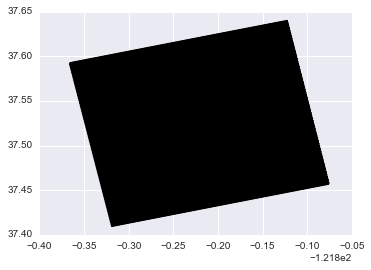

In [6]:
%time df = df.translate(xoff=141.3, yoff=-30, zoff=0.0)
%time df = df.translate(xoff=-122.2, yoff=37.4, zoff=0.0)
#df = df.translate(xoff=-122.6, yoff=37, zoff=0.0)
#df.plot()

In [34]:
from shapely.ops import cascaded_union
from rtree import index
idx = index.Index()


filtered_mon = mon
lats = filtered_mon['lat'].as_matrix()
lons = filtered_mon['lng'].as_matrix()
position_stack = np.dstack((lats,lons))
position_stack

# Populate R-tree index with bounds of grid cells
for pos, cell in enumerate(position_stack[0]):
    # assuming cell is a shapely object
    idx.insert(pos, (cell[0]))

# Loop through each Shapely polygon
#for poly in polygons:
#    # Merge cells that have overlapping bounding boxes
#    merged_cells = cascaded_union([grid_cells[pos] for pos in idx.intersection(poly.bounds)])
    # Now do actual intersection
#    print poly.intersection(merged_cells).area

AttributeError: 'numpy.ndarray' object has no attribute 'bounds'

CPU times: user 1.69 s, sys: 172 ms, total: 1.86 s
Wall time: 3min 23s


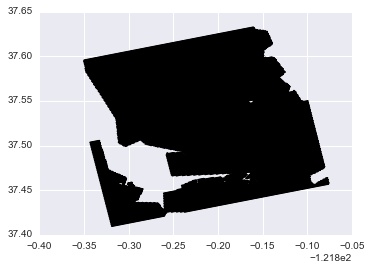

In [7]:

simple_ca_union = simple_ca.buffer(0).geometry.unary_union
final_circles = []

#    for c in df.geometry:
#        if simple_ca_union.intersects(c):
#            final_circles.append(c)

def filter_circles_not_inside(data):
    if simple_ca_union.intersects(data):
        return data
    else:
        return False

pool = multiprocessing.Pool(multiprocessing.cpu_count()-1)
%time final_circles = filter(lambda x: x != False, pool.map(filter_circles_not_inside, df.geometry))

search_circles = GeoDataFrame(geometry=GeoSeries(final_circles))
search_circles.plot(figsize=(30,30))

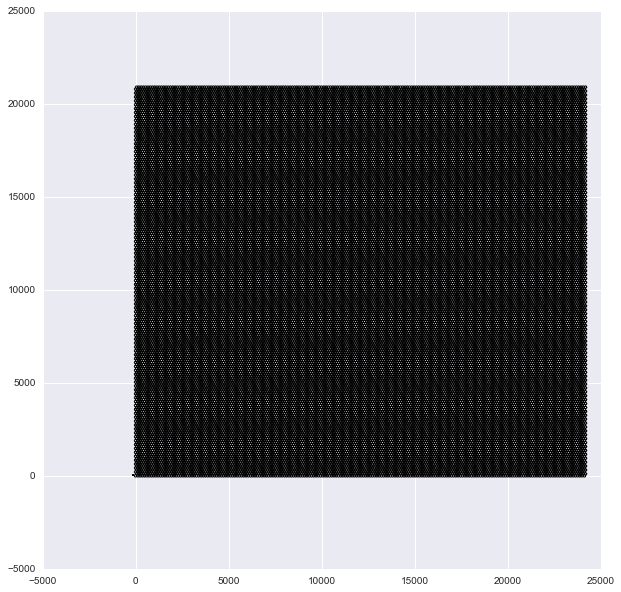

In [27]:
search_circles.plot(ax=ca_cities_clean.plot(figsize=(10,10)), figsize=(10,10))

In [13]:
search_circles.shape

(40000, 1)

In [ ]:
7.142857142857143*3852

In [ ]:
def chunks(l, n):
    n = max(1, n)
    return [l[i:i + n] for i in range(0, len(l), n)]
chunk = 20
# number of points, bins to plot.
bins = 130

filtered_mon_all = mon
# make plot using hexbin
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(1,2,1)


colormap = plt.cm.Set1


# draw coastlines, lat/lon lines.
m.drawcoastlines()
m.drawcountries()
m.drawstates()

#m.drawparallels(np.arange(0,81,20))
#m.drawmeridians(np.arange(-180,181,60))


#m.colorbar(location="bottom",label="Z", drawedges=True) # draw colorbar
#cb.ax.minorticks_on()
mnum=range(1,151)
colorbar_index(ncolors=151, mnum=mnum, cmap=colormap)   
patches = []
for poly in ca_cities_clean.geometry:
    if poly.geom_type == 'Polygon':
        mpoly = shapely.ops.transform(m, poly)
        patches.append(PolygonPatch(mpoly, fc="#FFFFFF", ec="#000000", alpha=0.9))
    elif poly.geom_type == 'MultiPolygon':
        for subpoly in poly:
            if subpoly.geom_type == 'Polygon':
                mpoly = shapely.ops.transform(m, subpoly)
                patches.append(PolygonPatch(mpoly,fc="#FFFFFF", ec="#000000", alpha=0.9))
    #else:
       # print(poly, " is neither a polygon nor a multi-polygon. Skipping it.")
ax.add_collection(PatchCollection(patches, match_original=True))


for mnum in chunks(range(1,151),chunk):


    filtered_mon = mon.query('num in '+str(mnum))
    #filtered_mon =  mons.query('num != 16 and num != 41 and num != 19 and num != 21 and num != 13 and num != 96 and num != 50')
    #filtered_mon =  mons.query('36<lat<38 and num > 98 and num < 104 ')

    lats = filtered_mon['lat'].as_matrix()
    lons = filtered_mon['lng'].as_matrix()
    nums = filtered_mon['num'].as_matrix()
    # convert to map projection coordinates.
    x, y = m(lons, lats)


    def reduce_c(x):
        #return mnum[0]
        return stats.mode(x)[0][0]

    plt.title('hexbin mon = '+str(mnum), fontsize=20)


    #CS = m.hexbin(x,y,gridsize=bins,cmap=plt.cm.jet, extent=[m.xmin,m.xmax,m.ymin,m.ymax])
    CS = m.hexbin(x,y,C=nums,reduce_C_function=reduce_c, gridsize=bins,cmap=colormap,
                 extent=[m.xmin,m.xmax,m.ymin,m.ymax], edgecolor='black', alpha=0.4)



    #plt.gcf().set_size_inches(20,20)
plt.show()
    #plt.savefig('mon'+str(mnum)+'.png')

In [ ]:
plotdat(filtered_mon,'num')